✅ 이미지 폴더 발견: /data/ephemeral/home/dataset/test
📄 데이터 로드 완료: 4871개


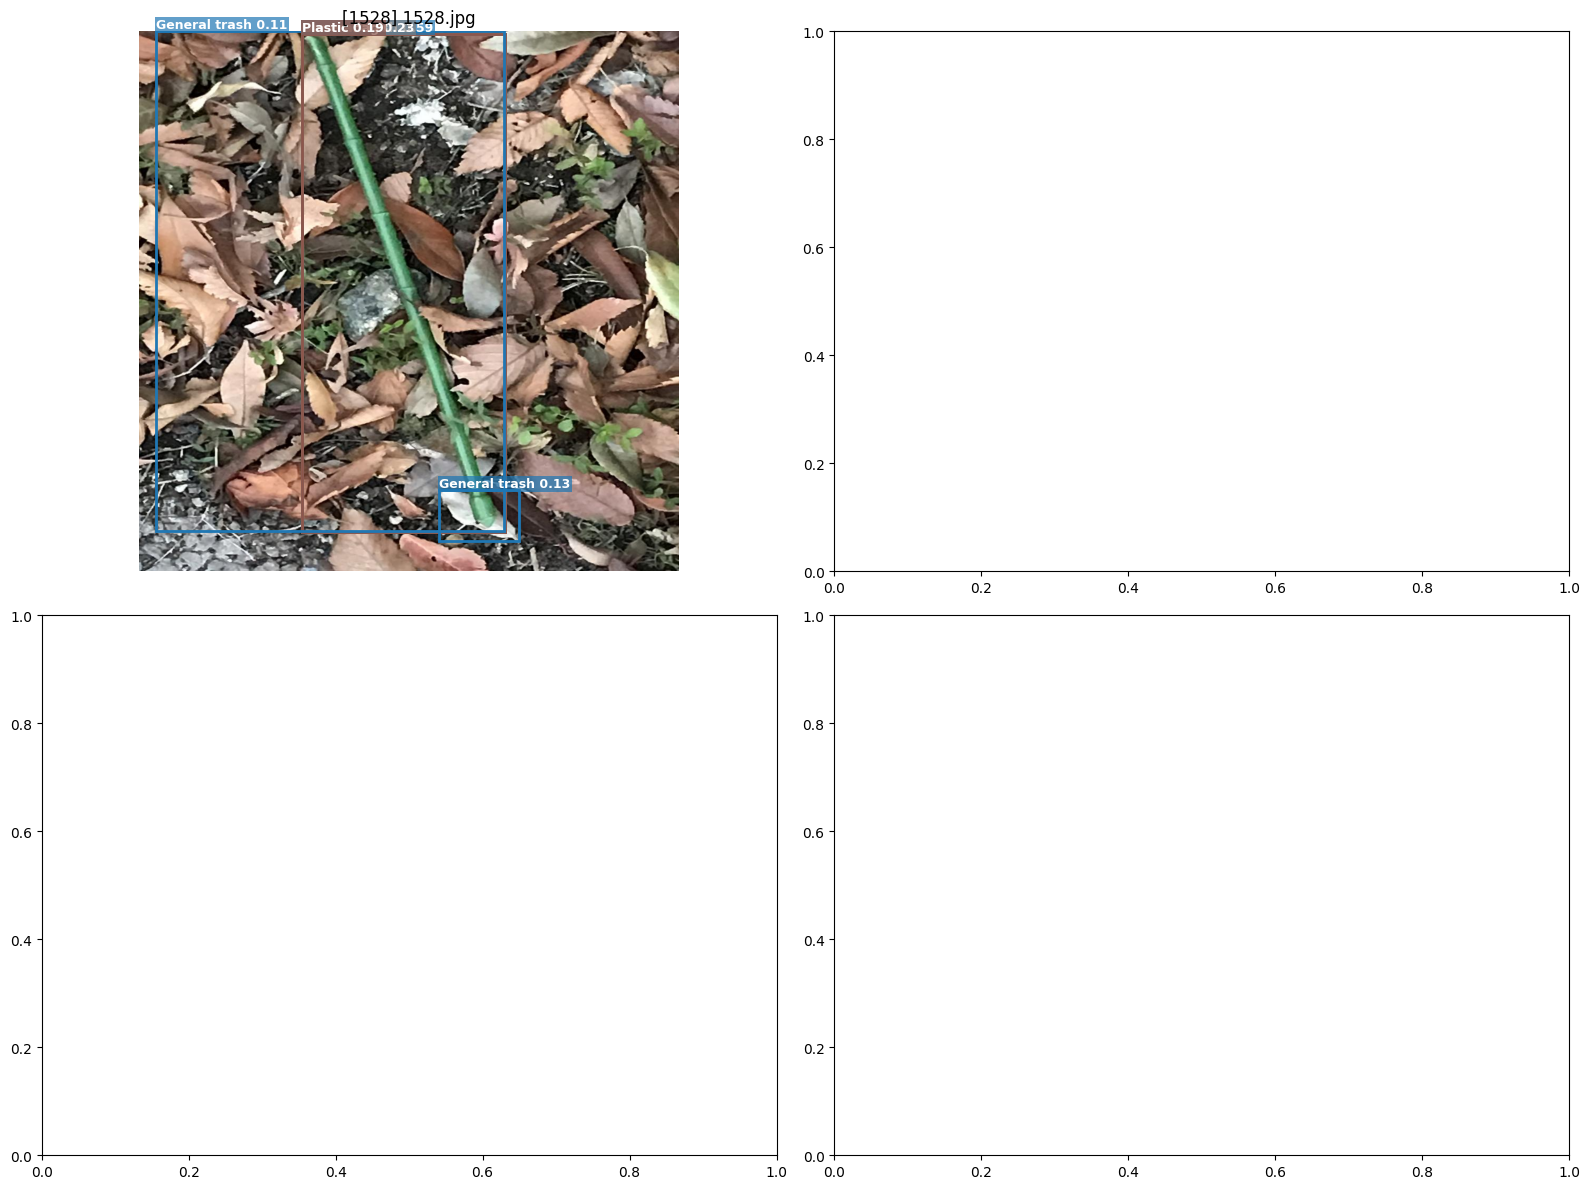

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import numpy as np

# ==========================
# 1. 경로 및 설정 (자동 탐색)
# ==========================
# CSV 파일 경로를 확인합니다. (현재 작업 디렉토리 기준)
# 만약 파일 경로가 다르다면 아래 CSV_PATH를 수정해주세요.
CSV_PATH = "./output_rfdetr.csv"
if not os.path.exists(CSV_PATH):
    # CSV 파일이 없다면, baseline 폴더 내에 있는지 확인합니다.
    CSV_PATH = "/data/ephemeral/home/output_rfdetr.csv"

# 데이터셋 루트 경로를 자동으로 찾습니다.
POSSIBLE_ROOTS = [
    "/data/ephemeral/home/dataset/test",
    "./dataset/test",
    "../../dataset/test",
    "/opt/ml/input/data/test" # 일반적인 AI Stages 데이터 경로
]

TEST_IMG_ROOT = None
for path in POSSIBLE_ROOTS:
    if os.path.exists(path):
        TEST_IMG_ROOT = path
        break

if TEST_IMG_ROOT is None:
    print("🚨 Error: 테스트 이미지 폴더를 찾을 수 없습니다.")
    print("POSSIBLE_ROOTS 리스트에 올바른 경로를 추가하거나, 직접 지정해주세요.")
    # 테스트를 위해 임시 경로 설정 (실행 시 에러 발생 가능)
    TEST_IMG_ROOT = "/data/ephemeral/home/dataset/test" 
else:
    print(f"✅ 이미지 폴더 발견: {TEST_IMG_ROOT}")


VIS_THRESHOLD = 0.1

CLASSES = [
    "General trash", "Paper", "Paper pack", "Metal", "Glass",
    "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"
]

# ==========================================
# 2. 시각화 실행
# ==========================================
if not os.path.exists(CSV_PATH):
    print(f"🚨 Error: CSV 파일을 찾을 수 없습니다: {CSV_PATH}")
else:
    df = pd.read_csv(CSV_PATH)
    print(f"📄 데이터 로드 완료: {len(df)}개")

    # 랜덤 샘플링
    sample_indices = np.random.choice(len(df), 4, replace=False)
    sample_indices = [1528]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, idx in enumerate(sample_indices):
        row = df.iloc[idx]
        image_id = row['image_id']      # 예: 0, 12 ...
        pred_str = row['PredictionString']

        # ★ [핵심] 파일명 변환 (0 -> 0000.jpg) 및 경로 결합
        try:
            # 숫자로 변환 후 4자리 포맷팅 (0000.jpg)
            file_name = f"{int(image_id):04d}.jpg"
        except ValueError:
            # 만약 'test/0000.jpg' 같은 문자열이라면 파일명만 추출
            file_name = os.path.basename(str(image_id))

        img_path = os.path.join(TEST_IMG_ROOT, file_name)

        ax = axes[i]

        # 이미지 로드 확인
        if not os.path.exists(img_path):
            print(f"❌ 경로에 파일이 없습니다: {img_path}")
            ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
            ax.set_title(file_name)
            continue

        img = cv2.imread(img_path)
        if img is None:
            ax.text(0.5, 0.5, 'Image Read Error', ha='center', va='center')
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"[{idx}] {file_name}", fontsize=12)

        # 박스 그리기
        if isinstance(pred_str, str) and len(pred_str.strip()) > 0:
            vals = pred_str.strip().split()
            # 6개씩 파싱: label, score, x1, y1, x2, y2
            for j in range(0, len(vals), 6):
                try:
                    label_idx = int(vals[j])
                    score = float(vals[j+1])
                    x1, y1, x2, y2 = map(float, vals[j+2:j+6])

                    if score < VIS_THRESHOLD:
                        continue

                    w, h = x2 - x1, y2 - y1
                    color = plt.cm.tab10(label_idx % 10)
                    class_name = CLASSES[label_idx]

                    rect = patches.Rectangle(
                        (x1, y1), w, h,
                        linewidth=2, edgecolor=color, facecolor='none'
                    )
                    ax.add_patch(rect)
                    ax.text(
                        x1, y1 - 5,
                        f"{class_name} {score:.2f}",
                        color='white', fontsize=9, fontweight='bold',
                        bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1)
                    )
                except (IndexError, ValueError):
                    pass

    plt.tight_layout()
    plt.show()

In [12]:
import os
import cv2
import pandas as pd
import math
import numpy as np
from tqdm import tqdm 

class_name={0:"General trash", 1:"Paper", 2:"Paper pack", 3:"Metal", 4:"Glass", 5:"Plastic", 6:"Styrofoam", 7:"Plastic bag", 8:"Battery", 9:"Clothing"}
class_colors = {
    "0": (255, 0, 0),
    "1": (0, 255, 0),
    "2": (0, 0, 255),
    "3": (255, 255, 0),
    "4": (255, 0, 255),
    "5": (0, 255, 255),
    "6": (128, 0, 128),
    "7": (128, 128, 0),
    "8": (0, 128, 128),
    "9": (0, 128, 255),
}

OUT_DIR='./predict_results'
os.makedirs(OUT_DIR, exist_ok=True)

df=pd.read_csv(CSV_PATH)

conf_threshold= 0.5
for idx, row in tqdm(df.iterrows(), total=len(df)):
    pred_str=row["PredictionString"]
    image_id=row["image_id"]
    # print(image_id)
    img_path=os.path.join("/data/ephemeral/home/dataset",image_id)
    # print(img_path)

    img=cv2.imread(img_path)


    tokens = pred_str.strip().split()
    # print(tokens)

    num_boxes=len(tokens)//6
    for i in range(num_boxes):
        label   = tokens[i * 6 + 0]
        score   = float(tokens[i * 6 + 1])
        x1      = float(tokens[i * 6 + 2])
        y1      = float(tokens[i * 6 + 3])
        x2      = float(tokens[i * 6 + 4])
        y2      = float(tokens[i * 6 + 5])

        if score>conf_threshold:
            
            x1_i, y1_i, x2_i, y2_i = map(int, [x1, y1, x2, y2])
            
            color = class_colors.get(label, (0, 255, 0))
            
            cv2.rectangle(img, (x1_i, y1_i), (x2_i, y2_i), color, 2)
            
            text = f"{class_name[int(label)]} {score:.2f}"
            (tw, th), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            
            cv2.rectangle(img, (x1_i, y1_i - th - baseline), (x1_i + tw, y1_i), color, -1)
            cv2.putText(
                img,
                text,
                (x1_i, y1_i - baseline),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 0),
                1,
                cv2.LINE_AA
            )
    out_filename = os.path.basename(image_id)   # 예: "0000.jpg"
    out_path = os.path.join(OUT_DIR, out_filename)
    cv2.imwrite(out_path, img)

    

100%|█████████████████████████████████████████████████████████████████████| 4871/4871 [03:33<00:00, 22.84it/s]
